# Exploratory Data Analysis

## Prix de Vente des Proprietées

In [36]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import quickda

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import seaborn as sns
import quickda

import warnings
warnings.filterwarnings('ignore')

In [37]:
# Set Fix Parame
    
SEED = 1234 # Seed for random  number geneartors

### Load  data

In [38]:


#ROOT_PATH = os.path.abspath(os.path.dirname(__file__))
data_folder = '../../data/raw/'


filenames = [  
               #'dvf_2018.gz',
              'dvf_2019.gz'
             ]

In [39]:
 # Util Fn to read write out a data sample from origina raw data files
 def pd_read_save(filename, sample_size, output_path):
 #    n = sum(1 for line in open(filename, errors = "ignore")) - 1 #number of records in file (excludes header)
 #    print("total rows")
 #    s = sample_size #desired sample sizfre
 #    skip = sorted(np.random.random_integers(1,n+1,n-s)) #the 0-indexed header will not be included in the skip list
     df = pd.read_csv(filename, error_bad_lines = False) #, skiprows=skip
     df_sample =  df.sample(sample_size, random_state = SEED)
     df_sample.to_csv(output_path, sep = ";", index = False)
     print('Writing file of shape: ', df_sample.shape)
     return df


 for f in filenames:
     data = data_folder + f
     print(data_folder  +'samples/'+f.split('.')[0]  +'_sample.csv.gz')
     pd_read_save( data, sample_size=400000, output_path = data_folder  +'samples/'+f.split('.')[0]  +'_sample.csv.gz')

../../data/raw/samples/dvf_2019_sample.csv.gz
Writing file of shape:  (400000, 40)


In [40]:
# Read saved data samples
    
dsets = {} #f.split('.')[0]: pd.DataFrame() for f in filenames

for f in filenames:
    base_name = f.split('.')[0]
    dsets[base_name] = pd.read_csv(  data_folder  + 'samples/' + base_name + '_sample.csv.gz'
                                   , error_bad_lines = False, sep = ';'
                                   )
    print(base_name, dsets[base_name].shape)



dvf_2019 (400000, 40)


#### Merge the Data Sets 

In [41]:
# Merge the data sets

data_in = pd.concat([dsets[d] for d in dsets.keys()])
print(data_in.shape) 
print(data_in.tail(2).T)

# Initial pre Analysis showed that  there are many duplicated rows.
data_in.drop_duplicates(inplace=True)
print(data_in.shape) 

# =============================================================================

(400000, 40)
                                       399998          399999
id_mutation                       2019-636554     2019-550724
date_mutation                      2019-10-07      2019-04-05
numero_disposition                          1               1
nature_mutation                         Vente           Vente
valeur_fonciere                        140000         75621.4
adresse_numero                              1             NaN
adresse_suffixe                           NaN             NaN
adresse_nom_voie                GR GRANDE RUE  LE PONT CORBIN
adresse_code_voie                        0032            B275
code_postal                             60190           53290
code_commune                            60040           53203
nom_commune                   Bailleul-le-Soc     Saint-Brice
code_departement                           60              53
ancien_code_commune                       NaN             NaN
ancien_nom_commune                        NaN            

### Explore Data 

In [42]:
data_in.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392096 entries, 0 to 399999
Data columns (total 40 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id_mutation                   392096 non-null  object 
 1   date_mutation                 392096 non-null  object 
 2   numero_disposition            392096 non-null  int64  
 3   nature_mutation               392096 non-null  object 
 4   valeur_fonciere               387603 non-null  float64
 5   adresse_numero                230232 non-null  float64
 6   adresse_suffixe               16687 non-null   object 
 7   adresse_nom_voie              387550 non-null  object 
 8   adresse_code_voie             387571 non-null  object 
 9   code_postal                   387546 non-null  float64
 10  code_commune                  392096 non-null  object 
 11  nom_commune                   392096 non-null  object 
 12  code_departement              392096 non-nul

In [43]:
# Get Proportion of Null values on Columns

#nulls_df = pd.DataFrame( {'Nulls': data_in.isnull().sum().values
#                        , 'Ptj':data_in.isnull().sum() /  data_in.shape[0]
#                        }
#                       )
#print(nulls_df)


# =============================================================================

## Data Summary
#Summary of the Row Data Set 

In [44]:
from quickda.explore_data import *
from quickda.clean_data import *
from quickda.explore_numeric import *
from quickda.explore_categoric import *
from quickda.explore_numeric_categoric import *
from quickda.explore_time_series import *


summary = explore(data_in, method="summarize")

Calculating dtypes...
Calculating count...
Calculating null_sum...
Calculating null_pct...
Calculating nunique...
Calculating min...
Calculating 25%...
Calculating 50%...
Calculating 75%...
Calculating max...
Calculating mean...
Calculating median...
Calculating std...
Calculating skew...


In [45]:

summary  # Display Raw Data Summary

summary



,dtypes,count,null_sum,null_pct,nunique,min,25%,50%,75%,max,mean,median,std,skew
adresse_code_voie,object,387571,4525,0.012,12389,-,-,-,-,-,-,-,-,-
adresse_nom_voie,object,387550,4546,0.012,155542,-,-,-,-,-,-,-,-,-
adresse_numero,float64,230232,161864,0.413,4419,1,8,24,87,9999,707.521,24,2035.87,3.10562
adresse_suffixe,object,16687,375409,0.957,37,-,-,-,-,-,-,-,-,-
ancien_code_commune,float64,647,391449,0.998,147,1091,36857.5,50503,78387.5,91182,52478.6,50503,25147.7,-0.239286
ancien_id_parcelle,object,137,391959,1.000,132,-,-,-,-,-,-,-,-,-
ancien_nom_commune,object,647,391449,0.998,147,-,-,-,-,-,-,-,-,-
code_commune,object,392096,0,0.000,26819,10002,-,-,-,97424,-,-,-,-
code_departement,object,392096,0,0.000,97,1,-,-,-,974,-,-,-,-
code_nature_culture,object,267465,124631,0.318,27,-,-,-,-,-,-,-,-,-


### Assign Features on Categories

In [46]:
#md Useful FtrsDrop Reason: They can not have missing values
#valeur_fonciere           (target cant have nulls)


#md High null pct ftrs

#adresse_suffixe                 0.958
#ancien_code_commune             0.991
#ancien_id_parcelle              0.999
#ancien_nom_commune              0.991
#code_nature_culture_speciale    0.954
#code_type_local                 0.476
#lot1_numero                     0.687
#lot1_surface_carrez             0.912
#lot2_numero                     0.935
#lot2_surface_carrez             0.979
#lot3_numero                     0.989
#lot3_surface_carrez             0.998
#lot4_numero                     0.996
#lot4_surface_carrez             0.999
#lot5_numero                     0.998
#lot5_surface_carrez             1.000
#nature_culture_speciale         0.954
#numero_volume                   0.997


#md Useful FtrsRedundant Features
#                               dtypes   count  null_sum  null_pct  nunique
#ancien_code_commune           float64    7004    778519     0.991      532   
#code_commune                   object  785523         0     0.000    31251   
#code_departement               object  785523         0     0.000       97   
#code_nature_culture            object  535959    249564     0.318       27   
#code_nature_culture_speciale   object   35761    749762     0.954      113   
#code_type_local               float64  411728    373795     0.476        4  


#md Useful Ftrs
#surface_reelle_bati           118074  0.590370  NaN 0
#nombre_pieces_principales      93279  0.466395  NaN 0
#nature_culture                 62293  0.311465  NaN "N/A"
#code_type_local NAN  "N/A"
#longitude                       4048  0.020240  k-neighb estim
#latitude                        4048  0.020240  k-neighb estim




### Setting Unuseful featues for analysis   Using above summary results



In [47]:

unuseful_ftrs = ['id_mutation', 'adresse_nom_voie', 'adresse_numero']

useful_high_ptc_ftrs = [  'adresse_numero'
                        , 'nombre_pieces_principales'
                        , 'type_local'
                        , 'surface_reelle_bati' 
                        , 'type_local'
                        ]

#Un inputable high nulls ftrs
ftrs_high_null_ptc = [f for f in summary.loc[summary.null_pct > 0.40,:].index  if f not in useful_high_ptc_ftrs]
#summary.loc[ftrs_high_null_ptc, 'null_pct']

useful_code_ftrs =  [
                     'code_postal'
                    ]

redundant_ftrs = [c for c in summary.index if 'code' in c and c not in useful_code_ftrs]
redundant_ftrs


unuseful_ftrs += sorted(list(set(ftrs_high_null_ptc).union(set(redundant_ftrs))))
unuseful_ftrs


ftrs = list(sorted([f for f in data_in.columns if f not in unuseful_ftrs])) 



In [48]:
# Inspect left useful ftrs
smmry4 = ['dtypes', 'count', 'null_pct', 'nunique']
summary.loc[ftrs, smmry4]





,dtypes,count,null_pct,nunique
code_postal,float64,387546,0.012,5699
date_mutation,object,392096,0.000,346
id_parcelle,object,392096,0.000,322782
latitude,float64,383893,0.021,306926
longitude,float64,383893,0.021,309029
nature_culture,object,267465,0.318,27
nature_mutation,object,392096,0.000,6
nom_commune,object,392096,0.000,25313
nombre_lots,int64,392096,0.000,41
nombre_pieces_principales,float64,205250,0.477,25


### Set useful Feature Groups

In [49]:
# Set useful Feature Groups

ftrs = list(sorted([f for f in data_in.columns if f not in unuseful_ftrs]))
target = 'valeur_fonciere'
ftrs.remove(target)

num_ftrs = list(summary.loc[summary.index.isin(ftrs) & (summary['dtypes'] != 'object'),:].index)
num_ftrs = [f for f in num_ftrs if f not in ['code_postal']] # Remove wrogly assigned num ftrs and target
data_in.loc[:,'code_postal'] = data_in.loc[:,'code_postal'].astype('str')

summary.loc[num_ftrs,smmry4]

date_ftrs = ['date_mutation']

cat_ftrs = list(summary.loc[summary.index.isin(ftrs)
                 & (summary['dtypes'] == 'object')
                 & (summary['nunique'] > 2 )
                 ,:].index
                )
cat_ftrs.append('code_postal')
bool_ftrs = []

# Assert all columns have bee assigned to a ftr class
all_solumns_assigned = len(set(data_in.columns).symmetric_difference(
        set(unuseful_ftrs + num_ftrs + cat_ftrs + date_ftrs + bool_ftrs + [target])))==0
assert(all_solumns_assigned)


data_in2 = data_in.loc[:, [target] + ftrs ]


for dt in [date_ftrs, num_ftrs, cat_ftrs]:
    print(summary.loc[dt, smmry4])

data_in2.tail(1).T

               dtypes   count  null_pct  nunique
date_mutation  object  392096       0.0      346
                            dtypes   count  null_pct  nunique
latitude                   float64  383893     0.021   306926
longitude                  float64  383893     0.021   309029
nombre_lots                  int64  392096     0.000       41
nombre_pieces_principales  float64  205250     0.477       25
numero_disposition           int64  392096     0.000      169
surface_reelle_bati        float64  158665     0.595     1638
surface_terrain            float64  267455     0.318    19045
                  dtypes   count  null_pct  nunique
date_mutation     object  392096     0.000      346
id_parcelle       object  392096     0.000   322782
nature_culture    object  267465     0.318       27
nature_mutation   object  392096     0.000        6
nom_commune       object  392096     0.000    25313
type_local        object  205507     0.476        4
code_postal      float64  387546     0.012

,399999
valeur_fonciere,75621.4
code_postal,53290.0
date_mutation,2019-04-05
id_parcelle,532030000B0275
latitude,47.8512
longitude,-0.428916
nature_culture,prés
nature_mutation,Vente
nom_commune,Saint-Brice
nombre_lots,0


##### Check Duplicates

In [50]:
#It seems like duplicates are sales with id_parcelle
#and valeur_fonciere when they are same more than once 

In [51]:
# Explore number of duplicated id parcells, This, inf fact should be a dropped field
by_id_parcells = data_in.groupby('id_parcelle')
#by_id_parcells.agg({'id_mutation': 'count'}).id_mutation.value_counts()#.plot.bar() #head()
by_parcell_mutations = by_id_parcells.agg({'id_mutation': 'count'}).reset_index()
# print(by_parcell_mutations.head())

nuni_ue_mutations_parcels = by_parcell_mutations.loc[
                                    by_parcell_mutations.id_mutation>1,'id_parcelle'] #filter parcels wit 2 or more mutations

nuni_ue = (data_in.loc[data_in.id_parcelle.isin(nuni_ue_mutations_parcels.values),:]
                    .sort_values(by=['id_parcelle']
                    )
          )
nuni_ue.tail(4).T

,312987,28008,135821,306513
id_mutation,2019-1062107,2019-1062107,2019-1062018,2019-1062107
date_mutation,2019-04-02,2019-04-02,2019-03-20,2019-04-02
numero_disposition,1,1,1,1
nature_mutation,Vente,Vente,Vente,Vente
valeur_fonciere,125000,125000,125500,125000
adresse_numero,63,63,63,63
adresse_suffixe,B,B,B,B
adresse_nom_voie,RUE PAUL HERMANN,RUE PAUL HERMANN,RUE PAUL HERMANN,RUE PAUL HERMANN
adresse_code_voie,1470,1470,1470,1470
code_postal,97430.0,97430.0,97430.0,97430.0


In [52]:

# Drop duplicate properties
id_ftrs = ['id_parcelle'
           #, 'id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation'
           , 'valeur_fonciere'
           ]
data = data_in2.drop_duplicates(subset=id_ftrs, keep='last')
print(data.shape)



(362827, 15)




### Explore Target Feature

#First Plotting target_value in thousands to facilitate visualization





#Original target values are very left skewed

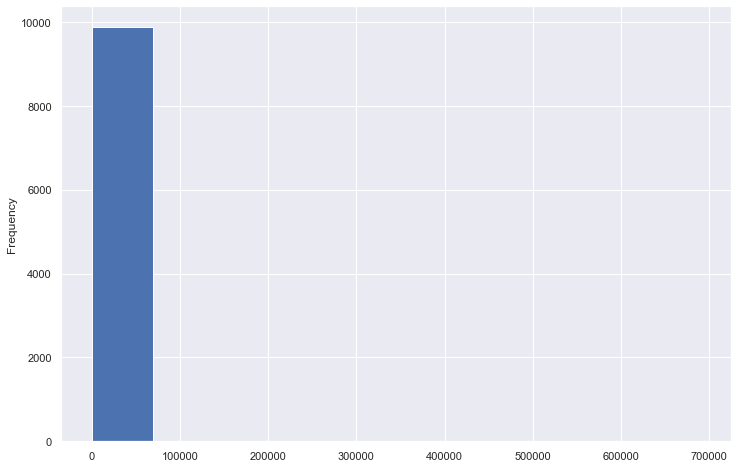

In [53]:
###### Add sale value in thousands for easiest management
###### Now plot log of target value
df_plot = data.sample(10000, random_state=SEED)

fig, ax = plt.subplots(figsize=(12,8))
(df_plot.valeur_fonciere/1000).plot.hist(ax = ax, bins = 10)
#sns.histplot(df_plot.valeur_fonciere/1000, ax=ax,  kde=False)
plt.show()





#Applying log transformations gives a very centered distribution, There is, however a small separated group of very low valuew which can, maybe be inspected to see if they are outliers.

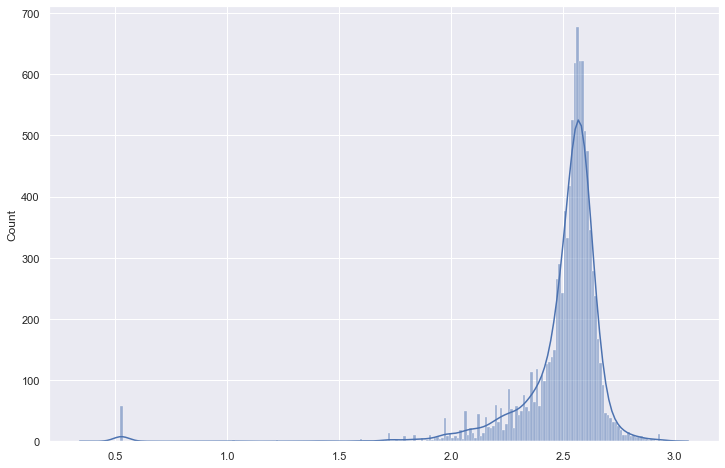

In [54]:
# We add the scaled target value to use

data['valeur_fonciere_log'] = np.log1p(data['valeur_fonciere'])

# Now plot log of target value
df_plot = data.sample(10000, random_state=SEED)

fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(np.log1p(df_plot.valeur_fonciere_log.values), ax=ax,  kde=True)
plt.show()

In [55]:


outlier_thr =  np.expm1(4.5)
print('Outlier threshold:', outlier_thr)
print(  data.loc[data['valeur_fonciere_log']<4.5,:].shape
      , data.loc[data['valeur_fonciere']<outlier_thr,:].shape)

print('Prop of outliers: {:.2f}'.format(
        data.loc[data['valeur_fonciere_log']<4.5,:].shape[0]/ data.shape[0]))

Outlier threshold: 89.01713130052181
(3384, 16) (3384, 16)
Prop of outliers: 0.01


In [56]:
# Log distrib is centered but there is a small cluster on values close to 0. Let's explore it

identity_ftrs = ['id_parcelle', 'latitude', 'longitude',  'nature_culture']
atypic_low = data.loc[data.valeur_fonciere_log<1, :].sort_values(by=['valeur_fonciere', 'id_parcelle'])
#atypic_low.show()
atypic_low.shape[0] / data.shape[0]

atypic_low.shape

(2624, 16)

In [57]:
data.loc[data.valeur_fonciere_log<1, :].sort_values(by=['id_parcelle', 'valeur_fonciere']).head(100).nature_culture.value_counts()



sols                   56
terres                 16
terrains a bâtir        7
terrains d'agrément     4
landes                  3
taillis simples         3
prés                    3
jardins                 2
eaux                    1
Name: nature_culture, dtype: int64

### Exploratoty Analysis




###  Categorical features vs Target

In [58]:

# Set low cardinality features subset
summary.loc[summary.index.isin(cat_ftrs),:]

cat_ftrs_nunique_low = summary.loc[  summary.index.isin(cat_ftrs) & (summary['nunique'] < 28)
                                       , summary.columns[0:5]].index



### Plot each categorical value vs Target
#We see that for nature_mutation and culture_nature categories seem to influence target while type_local ones don't seem to have an impact. 

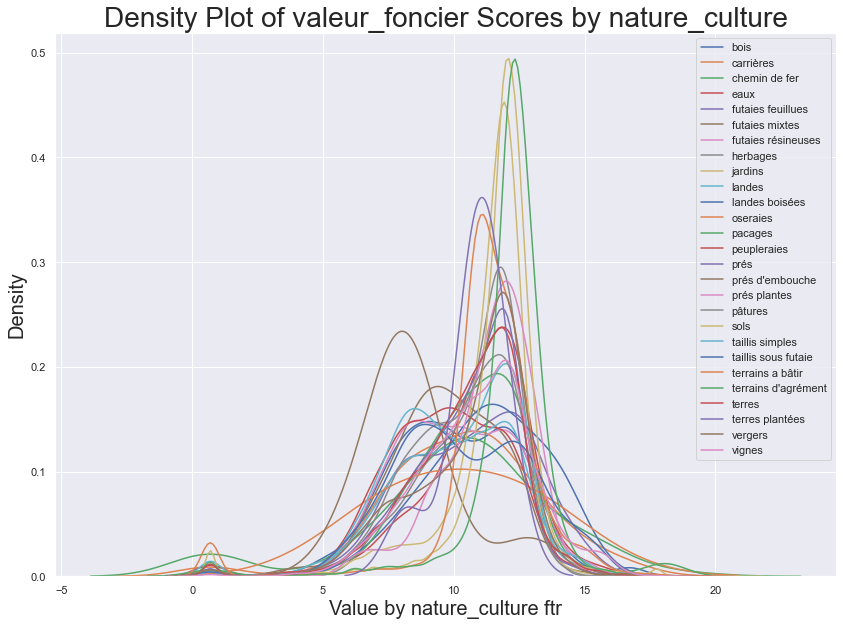

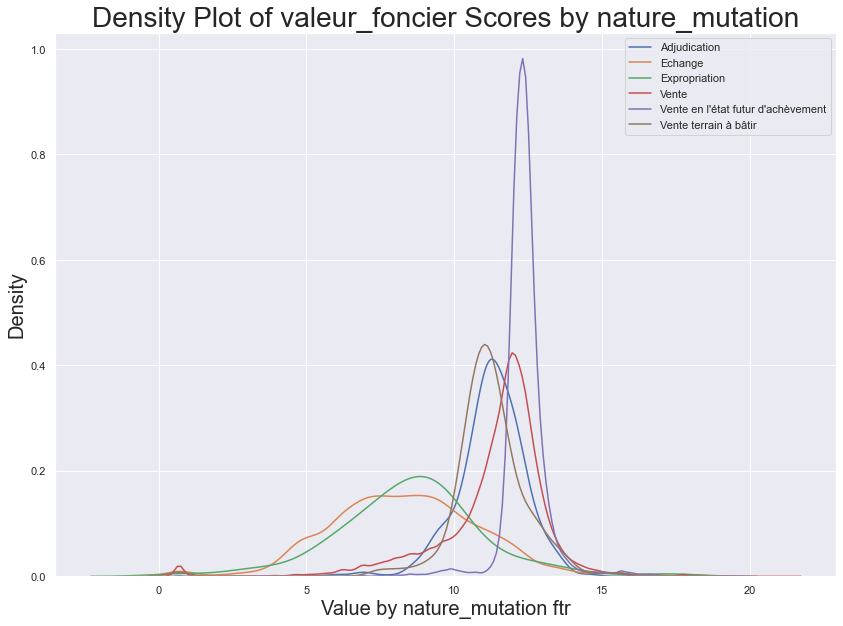

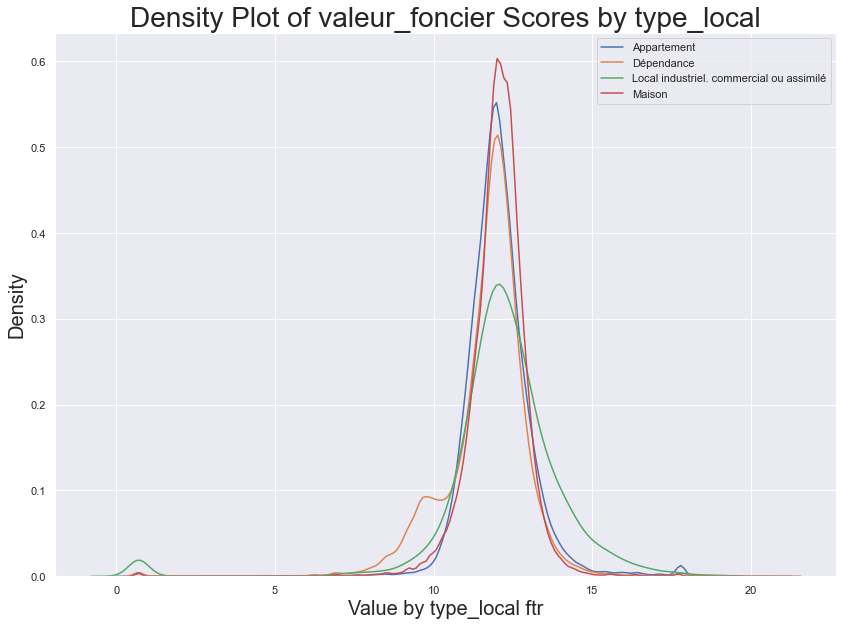

In [59]:
# Plot each categorical value vs Target
for f in cat_ftrs_nunique_low:
    data.loc[:,f] = data[f].astype('category')
    fig, ax = plt.subplots(figsize = (14,10))
    for cat in data.loc[:,f].cat.categories:
#        print(f,cat)
        # Select the category type
        subset = data.loc[data[f] == cat, :]
        
        # Density plot of Energy Star scores
        sns.kdeplot(subset['valeur_fonciere_log'].dropna(),
                   label = cat, shade = False, alpha = 0.8);
    
    # label the plot
    ax.legend()
    plt.xlabel('Value by {} ftr'.format(f), size = 20); plt.ylabel('Density', size = 20); 
    plt.title('Density Plot of {} Scores by {}'.format('valeur_foncier', f), size = 28);
    plt.show()



### Inspect Numeric Features
    
#By inspecting continuous features against the target we found next discoveries:
#1. Nombre de lots, surface reel batie et nombre de pieces principales semblent avoir
#2. Longitude et Latitude aussi semblen avoir une influence cépendant il existe un  petit cluster separé des autres dans lon[5,15] et lat [-60, -50]. Possibly delete these and not make predictions for outside Euope Continent France Territories
#Other numeric features dont seem to have an important contribution on value

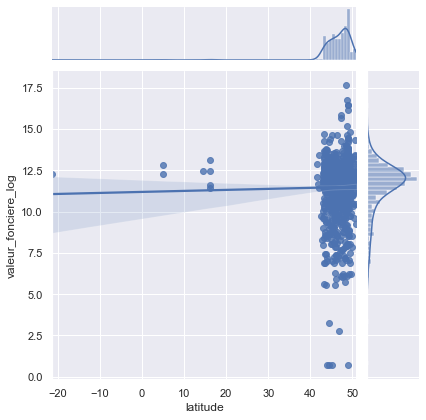

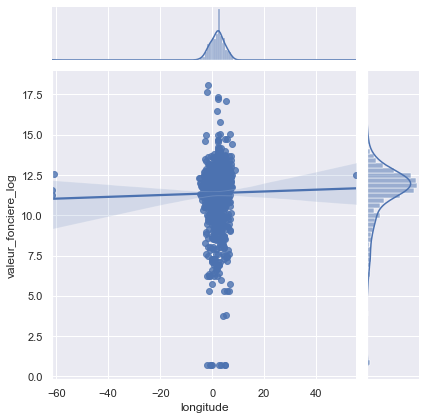

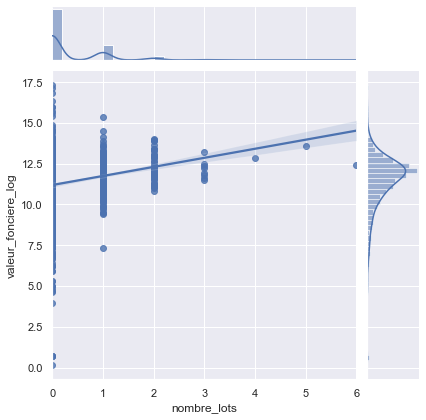

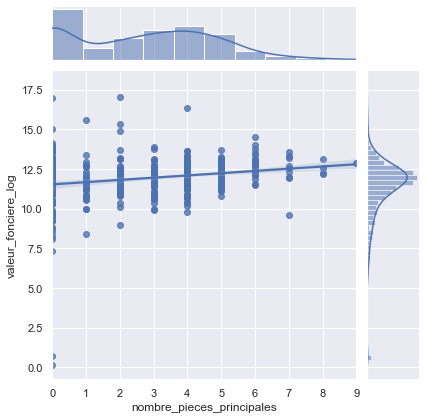

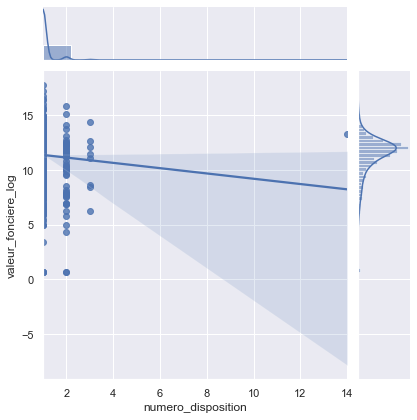

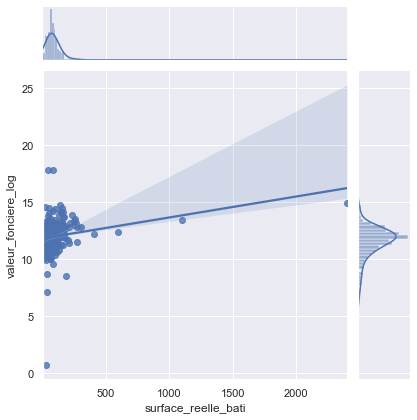

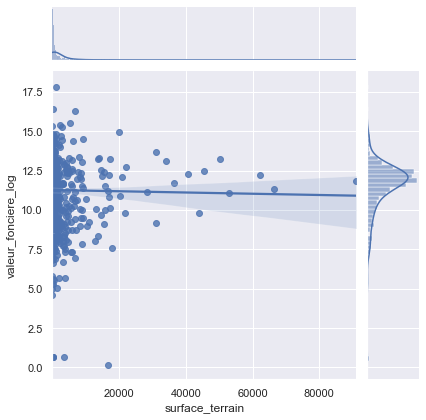

In [60]:

for f in num_ftrs:
    data_plt = data.sample(1000, )
    sns.jointplot(x=f, y='valeur_fonciere_log', data=data_plt, kind="reg")
    plt.show()


#% On the other hand, features are not highly correlated to each other

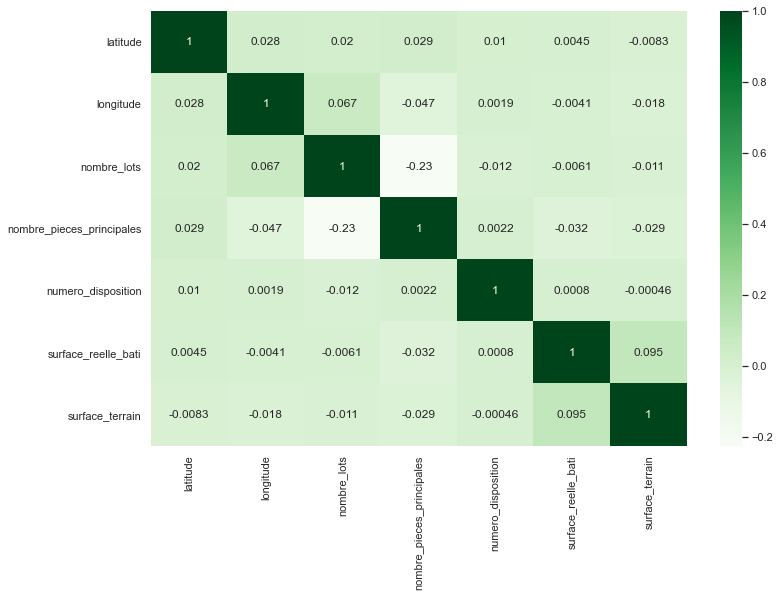

In [61]:
#eda_num(data.loc[:,num_ftrs], method='correlation')
    
corr =  data.loc[:,num_ftrs].corr(method = 'pearson')
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap="Greens")
plt.show()



In [62]:
### Predictive Capacity of Features
# Finally we inspect the predictive capacity of the features

In [81]:
pred_mtx = eda_numcat(data, x=None, y='valeur_foncier', method="pps")

Predictive Power Score - Heatmap


In [82]:
pred_mtx

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,valeur_fonciere,valeur_fonciere,1.00,predict_itself,True,None,0.00,1.00,None
1,valeur_fonciere,code_postal,0.00,classification,True,weighted F1,0.00,0.01,DecisionTreeClassifier()
2,valeur_fonciere,date_mutation,0.00,classification,True,weighted F1,0.00,0.01,DecisionTreeClassifier()
3,valeur_fonciere,id_parcelle,0.00,unknown_error,False,None,0.00,0.00,None
4,valeur_fonciere,latitude,0.00,regression,True,mean absolute error,2.03,2.39,DecisionTreeRegressor()
5,valeur_fonciere,longitude,0.00,regression,True,mean absolute error,2.34,2.89,DecisionTreeRegressor()
6,valeur_fonciere,nature_culture,0.09,classification,True,weighted F1,0.30,0.36,DecisionTreeClassifier()
7,valeur_fonciere,nature_mutation,0.00,classification,True,weighted F1,0.87,0.87,DecisionTreeClassifier()
8,valeur_fonciere,nom_commune,0.00,classification,True,weighted F1,0.00,0.01,DecisionTreeClassifier()
9,valeur_fonciere,nombre_lots,0.00,regression,True,mean absolute error,0.41,0.55,DecisionTreeRegressor()


#### Export Summary of features to use

In [65]:
# Make sunmary of all original colunns and left rows
summary_out = explore(data_in.loc[data.index,:], method="summarize")
summary_out

Calculating dtypes...
Calculating count...
Calculating null_sum...
Calculating null_pct...
Calculating nunique...
Calculating min...
Calculating 25%...
Calculating 50%...
Calculating 75%...
Calculating max...
Calculating mean...
Calculating median...
Calculating std...
Calculating skew...


,dtypes,count,null_sum,null_pct,nunique,min,25%,50%,75%,max,mean,median,std,skew
adresse_code_voie,object,359396,3431,0.009,12388,-,-,-,-,-,-,-,-,-
adresse_nom_voie,object,359375,3452,0.010,155451,-,-,-,-,-,-,-,-,-
adresse_numero,float64,206228,156599,0.432,4414,1,8,24,85,9999,699.489,24,2016.85,3.11656
adresse_suffixe,object,15057,347770,0.959,37,-,-,-,-,-,-,-,-,-
ancien_code_commune,float64,631,362196,0.998,147,1091,35344,50503,78387.5,91182,52338.7,50503,25258.4,-0.240591
ancien_id_parcelle,object,134,362693,1.000,132,-,-,-,-,-,-,-,-,-
ancien_nom_commune,object,631,362196,0.998,147,-,-,-,-,-,-,-,-,-
code_commune,object,362827,0,0.000,26819,10002,-,-,-,97424,-,-,-,-
code_departement,object,362827,0,0.000,97,1,-,-,-,974,-,-,-,-
code_nature_culture,object,254211,108616,0.299,27,-,-,-,-,-,-,-,-,-
